<a href="https://colab.research.google.com/github/NinaAbeyratne/Cybersecurity-IDS-Optimization-GA/blob/main/Preprocessing_CI_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [2]:
# Install required packages
# !pip install deap scikit-learn pandas numpy matplotlib seaborn imbalanced-learn -q

In [3]:
# Import all libraries
import numpy as np, joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import random
import json
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from deap import base, creator, tools
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All dependencies installed and imported successfully")

✓ All dependencies installed and imported successfully


Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the dataset

In [5]:
import pandas as pd
import os

In [6]:
# Set path to your CICIDS2017 dataset folder in Drive
data_dir = '/content/drive/MyDrive/CI CW/CICIDS2017/'

# Get list of all CSV files
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
print(f"Found {len(csv_files)} CSV files in {data_dir}")

# Load all CSVs into a list of DataFrames
uploaded_dataframes = []
for filename in csv_files:
    file_path = os.path.join(data_dir, filename)
    print(f"Loading {filename}...")
    df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
    uploaded_dataframes.append(df)
    print(f"  Loaded {len(df)} rows, {len(df.columns)} columns")

print(f"\n✓ Total files loaded: {len(uploaded_dataframes)}")

Found 8 CSV files in /content/drive/MyDrive/CI CW/CICIDS2017/
Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
  Loaded 225745 rows, 79 columns
Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
  Loaded 286467 rows, 79 columns
Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
  Loaded 191033 rows, 79 columns
Loading Monday-WorkingHours.pcap_ISCX.csv...
  Loaded 529918 rows, 79 columns
Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
  Loaded 288602 rows, 79 columns
Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
  Loaded 170366 rows, 79 columns
Loading Tuesday-WorkingHours.pcap_ISCX.csv...
  Loaded 445909 rows, 79 columns
Loading Wednesday-workingHours.pcap_ISCX.csv...
  Loaded 692703 rows, 79 columns

✓ Total files loaded: 8


In [7]:
print(df.head)

<bound method NDFrame.head of          Destination Port   Flow Duration   Total Fwd Packets  \
0                      80           38308                   1   
1                     389             479                  11   
2                      88            1095                  10   
3                     389           15206                  17   
4                      88            1092                   9   
...                   ...             ...                 ...   
692698                 53           32215                   4   
692699                 53             324                   2   
692700              58030              82                   2   
692701                 53         1048635                   6   
692702                 53           94939                   4   

         Total Backward Packets  Total Length of Fwd Packets  \
0                             1                            6   
1                             5                          172 

## Class Distribution - BEFORE cleaning

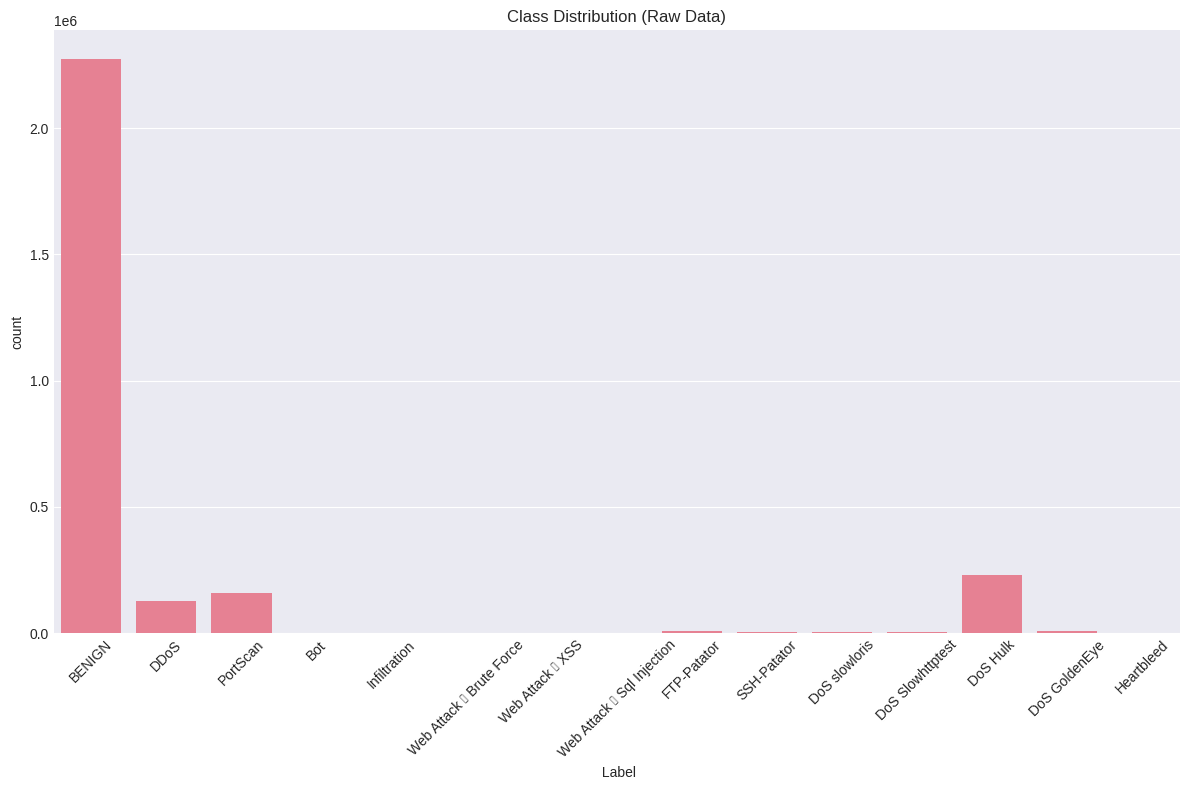

In [8]:
plt.figure(figsize=(12,8))
data_raw = pd.concat(uploaded_dataframes, ignore_index=True)

label_col_raw = [c for c in data_raw.columns if 'label' in c.lower()][0]

sns.countplot(x=data_raw[label_col_raw])
plt.title("Class Distribution (Raw Data)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Preprocessing Class

In [9]:
class CICIDS2017Preprocessor:
    """
    Multiclass Preprocessor for CICIDS2017 intrusion detection dataset
    """

    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = None
        self.class_names = None

    def load_data(self, dataframes, max_rows_per_file=None):
        """Load data from list of dataframes"""
        print("Loading CICIDS2017 dataset...")

        processed_dfs = []
        for i, df in enumerate(dataframes):
            if max_rows_per_file:
                df = df.head(max_rows_per_file)
            processed_dfs.append(df)
            print(f"  File {i+1}: {len(df)} rows")

        data = pd.concat(processed_dfs, ignore_index=True)
        print(f"\nTotal rows loaded: {len(data)}")
        print(f"Total columns: {len(data.columns)}")

        return data

    def clean_data(self, data):
        """Clean dataset"""
        print("\nCleaning data...")
        initial_rows = len(data)

        # Strip whitespace from column names
        data.columns = data.columns.str.strip()

        # Find label column
        label_cols = [col for col in data.columns if 'label' in col.lower()]
        if not label_cols:
            raise ValueError("Could not find label column")

        label_col = label_cols[0]
        print(f"Using label column: '{label_col}'")

        # Replace infinite values
        data = data.replace([np.inf, -np.inf], np.nan)

        # Drop NaN
        data = data.dropna()
        print(f"Removed {initial_rows - len(data)} rows with missing/infinite values")

        # Remove duplicates
        duplicates = data.duplicated().sum()
        data = data.drop_duplicates()
        print(f"Removed {duplicates} duplicate rows")

        print(f"Clean dataset: {len(data)} rows")

        # Remove extremely rare classes (important for SMOTE stability)
        min_samples = 10
        label_counts = data[label_col].value_counts()

        rare_labels = label_counts[label_counts < min_samples].index.tolist()

        if rare_labels:
            print("\nRemoving rare classes (too few samples for SMOTE):")
            for lbl in rare_labels:
                print(f"  {lbl}: {label_counts[lbl]} samples")

            data = data[~data[label_col].isin(rare_labels)]

        print(f"Dataset after rare-class filtering: {len(data)} rows")


        return data, label_col

    def encode_labels(self, data, label_col):
        """Multiclass label Encoding"""
        print("\nEncoding labels...")

        unique_labels = data[label_col].value_counts()
        print(f"Found {len(unique_labels)} unique labels:")
        for label, count in unique_labels.items():
            print(f"  {label}: {count} samples")

        y = self.label_encoder.fit_transform(data[label_col])
        self.class_names = self.label_encoder.classes_

        print("\nEncoded class mapping:")
        for idx, name in enumerate(self.class_names):
            print(f"  {idx}: {name}")

        print(f"Encoded labels: {len(y)} samples")

        return y

    def plot_class_distribution(self, y):
        plt.figure(figsize=(10,5))
        sns.countplot(x=y)
        plt.title("Multiclass Distribution (After Cleaning & Encoding)")
        plt.xlabel("Class ID")
        plt.ylabel("Sample Count")
        plt.tight_layout()
        plt.show()

    def prepare_features(self, data, label_col):
        """Prepare feature matrix"""
        print("\nPreparing features...")

        # Columns to exclude
        exclude_cols = [label_col]

        # Exclude timestamp/IP columns
        for col in data.columns:
            col_lower = col.lower().strip()
            if any(x in col_lower for x in ['timestamp', 'time', 'date', 'ip', 'port']):
                if col not in exclude_cols:
                    exclude_cols.append(col)
                    print(f"  Excluding: {col}")

        # Select features
        X = data.drop(columns=exclude_cols, errors='ignore')

        # Convert to numeric
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')

        X = X.dropna(axis=1, how='all')

        self.feature_names = X.columns.tolist()
        print(f"Feature matrix: {X.shape[0]} samples, {X.shape[1]} features")

        return X

    def scale_features(self, X_train, X_val, X_test):
        """Scale features"""
        print("\nScaling features...")

        self.scaler.fit(X_train)

        print("Scaling complete")

        return (
            self.scaler.transform(X_train),
            self.scaler.transform(X_val),
            self.scaler.transform(X_test),
        )

    def split_data(self, X, y, test_size=0.15, val_size=0.15, random_state=42):
        """Split into train/val/test"""
        print(f"\nSplitting data (test={test_size}, val={val_size})...")

        # First split: test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state
        )

        # Second split: validation set
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, stratify=y_temp, random_state=random_state
        )

        print("\nApplying SMOTE to balance training data...")

        smote = SMOTE(random_state=42, k_neighbors=3)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        print("Training class distribution after SMOTE:")
        unique, counts = np.unique(y_train, return_counts=True)
        for u, c in zip(unique, counts):
            print(f"  {self.class_names[u]}: {c}")

        print(f"\nTraining:   {len(X_train)} samples")
        print(f"Validation: {len(X_val)} samples")
        print(f"Test:       {len(X_test)} samples")

        return X_train, X_val, X_test, y_train, y_val, y_test

print("✓ Preprocessor class defined")

✓ Preprocessor class defined


# Run Preprocessing

In [10]:
# Initialize preprocessor
preprocessor = CICIDS2017Preprocessor()

# Load data (adjust max_rows_per_file for testing)
data = preprocessor.load_data(
    uploaded_dataframes,
    max_rows_per_file=50000  # Remove or increase for full dataset
)

Loading CICIDS2017 dataset...
  File 1: 50000 rows
  File 2: 50000 rows
  File 3: 50000 rows
  File 4: 50000 rows
  File 5: 50000 rows
  File 6: 50000 rows
  File 7: 50000 rows
  File 8: 50000 rows

Total rows loaded: 400000
Total columns: 79


In [11]:
# Clean data
data, label_col = preprocessor.clean_data(data)


Cleaning data...
Using label column: 'Label'
Removed 313 rows with missing/infinite values
Removed 13793 duplicate rows
Clean dataset: 385894 rows

Removing rare classes (too few samples for SMOTE):
  Bot: 2 samples
Dataset after rare-class filtering: 385892 rows


In [12]:
# Encode labels
y = preprocessor.encode_labels(data, label_col)


Encoding labels...
Found 6 unique labels:
  BENIGN: 354138 samples
  DDoS: 23864 samples
  FTP-Patator: 4082 samples
  DoS slowloris: 2535 samples
  Web Attack � Brute Force: 1060 samples
  PortScan: 213 samples

Encoded class mapping:
  0: BENIGN
  1: DDoS
  2: DoS slowloris
  3: FTP-Patator
  4: PortScan
  5: Web Attack � Brute Force
Encoded labels: 385892 samples


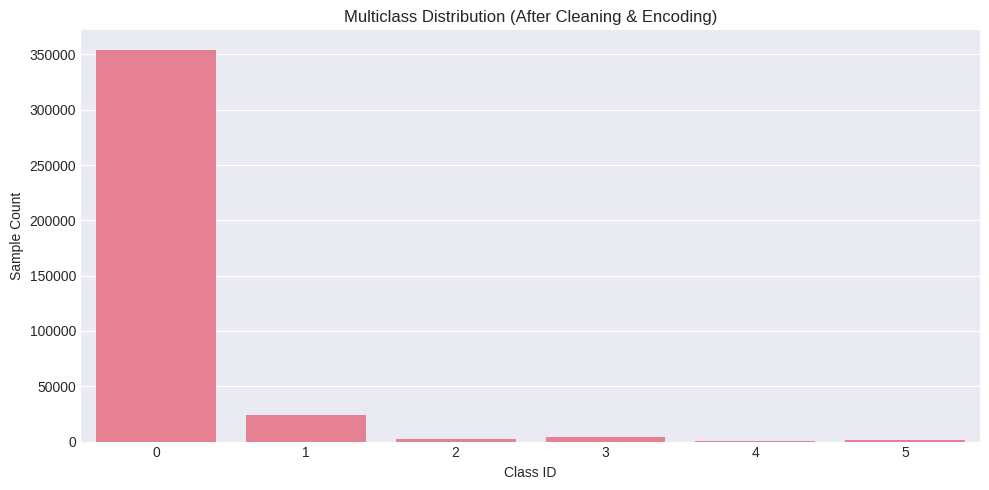

In [13]:
# Plot class distribution (outside the class)
preprocessor.plot_class_distribution(y)

In [14]:
# Prepare features
X = preprocessor.prepare_features(data, label_col)
feature_names = preprocessor.feature_names


Preparing features...
  Excluding: Destination Port
Feature matrix: 385892 samples, 77 features


In [15]:
# Split data
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(X, y)


Splitting data (test=0.15, val=0.15)...

Applying SMOTE to balance training data...
Training class distribution after SMOTE:
  BENIGN: 247896
  DDoS: 247896
  DoS slowloris: 247896
  FTP-Patator: 247896
  PortScan: 247896
  Web Attack � Brute Force: 247896

Training:   1487376 samples
Validation: 57884 samples
Test:       57884 samples


In [16]:
X_train_raw = X_train.copy()   # BEFORE scaling

In [17]:
# Scale features
X_train_scaled, X_val_scaled, X_test_scaled = preprocessor.scale_features(
    X_train, X_val, X_test
)


Scaling features...
Scaling complete


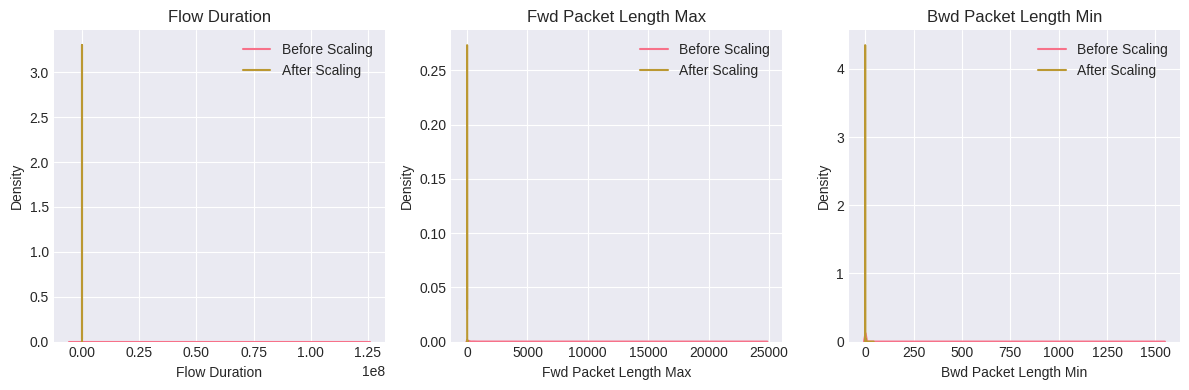

In [19]:
# Feature Scale Distribution
feature_indices = [0, 5, 10]

plt.figure(figsize=(12,4))
for i, idx in enumerate(feature_indices, 1):
    plt.subplot(1, 3, i)
    sns.kdeplot(X_train_raw.iloc[:, idx], label='Before Scaling')
    sns.kdeplot(X_train_scaled[:, idx], label='After Scaling')
    plt.title(feature_names[idx])
    plt.legend()

plt.tight_layout()
plt.show()

This visualization shows how standardization transforms features with different original ranges into a common scale, ensuring fair contribution during model training

In [20]:
# Save the Scaler
joblib.dump(preprocessor.scaler, 'scaler.joblib')
print("✓ Scaler saved")

✓ Scaler saved


In [21]:
feature_names = preprocessor.feature_names

print("\n" + "="*60)
print("PREPROCESSING COMPLETE")
print("="*60)
print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_test)}")
print(f"Number of features: {len(feature_names)}")


PREPROCESSING COMPLETE
Training samples: 1487376
Validation samples: 57884
Test samples: 57884
Number of features: 77


# Save Preprocessed data

In [23]:
save_path = '/content/drive/MyDrive/CI CW/preprocessed_data.npz'

np.savez(
    save_path,
    X_train=X_train_scaled,
    X_val=X_val_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    feature_names=feature_names,
    class_names=preprocessor.class_names

)

print("✓ Preprocessed data saved")

✓ Preprocessed data saved


In [25]:
print(np.unique(y_train))

[0 1 2 3 4 5]


# Baseline Model Training

In [34]:
import sys

print("="*60)
print("BASELINE MODEL TRAINING")
print("="*60)

# Train Random Forest baseline
print("\nTraining regularized baseline Random Forest...")
rf_baseline = RandomForestClassifier(
    n_estimators=150,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
    max_features='sqrt',
    class_weight='balanced'
)

# Training time
start_time = time.time()
rf_baseline.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

# Inference time
start_time = time.time()
y_train_pred = rf_baseline.predict(X_train_scaled)
y_val_pred = rf_baseline.predict(X_val_scaled)
inference_time = time.time() - start_time

baseline_metrics = {
    'train_f1_macro': f1_score(y_train, y_train_pred, average='macro'),
    'val_f1_macro': f1_score(y_val, y_val_pred, average='macro'),
    'val_f1_weighted': f1_score(y_val, y_val_pred, average='weighted'),
    'accuracy': accuracy_score(y_val, y_val_pred),
    'train_time': train_time,
    'inference_time': inference_time,
    'inference_time_per_sample': inference_time / len(X_val_scaled),
    'model_size_kb': sys.getsizeof(rf_baseline) / 1024,
    'precision_macro': precision_score(y_val, y_val_pred, average='macro', zero_division=0),
    'recall_macro': recall_score(y_val, y_val_pred, average='macro', zero_division=0)
}

print("\nBaseline Validation Metrics:")
for k, v in baseline_metrics.items():
    if 'time' in k:
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v:.4f}")

print("\n✓ Regularized Baseline training complete")

BASELINE MODEL TRAINING

Training regularized baseline Random Forest...

Baseline Validation Metrics:
  train_f1_macro: 0.9992
  val_f1_macro: 0.9372
  val_f1_weighted: 0.9972
  accuracy: 0.9966
  train_time: 781.4769
  inference_time: 18.7975
  inference_time_per_sample: 0.0003
  model_size_kb: 0.0469
  precision_macro: 0.9095
  recall_macro: 0.9970

✓ Regularized Baseline training complete


The initial Random Forest baseline exhibited signs of overfitting due to unrestricted tree depth. To improve generalization, regularization was introduced by limiting tree depth and enforcing minimum samples per split and leaf.

In addition to classification performance, training time, inference latency, and model size were recorded to assess the computational efficiency of the proposed approach.

### Overfitting Check Plot (Multiclass)

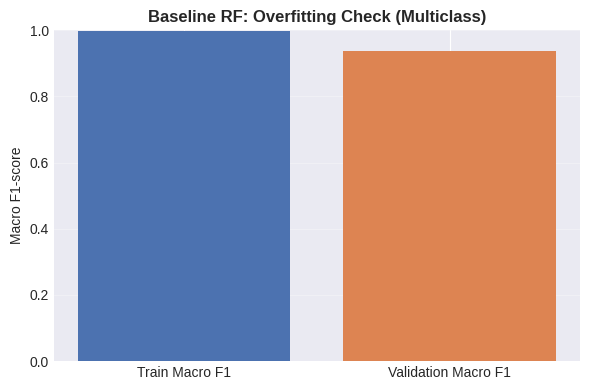

In [35]:
plt.figure(figsize=(6,4))
plt.bar(
    ['Train Macro F1', 'Validation Macro F1'],
    [
        baseline_metrics['train_f1_macro'],
        baseline_metrics['val_f1_macro']
    ],
    color=['#4C72B0', '#DD8452']
)

plt.title('Baseline RF: Overfitting Check (Multiclass)', fontweight='bold')
plt.ylim(0, 1)
plt.ylabel('Macro F1-score')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### with weighted F1

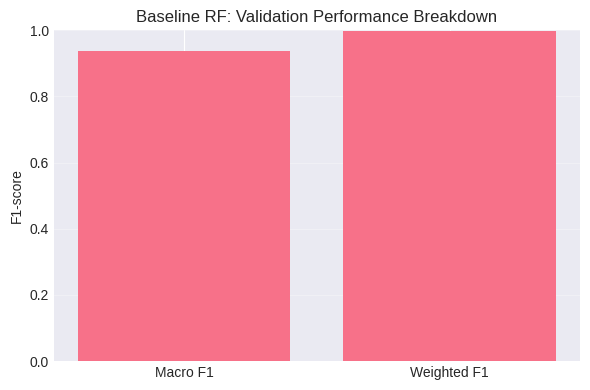

In [36]:
plt.figure(figsize=(6,4))
plt.bar(
    ['Macro F1', 'Weighted F1'],
    [
        baseline_metrics['val_f1_macro'],
        baseline_metrics['val_f1_weighted']
    ]
)

plt.title('Baseline RF: Validation Performance Breakdown')
plt.ylim(0, 1)
plt.ylabel('F1-score')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## Confusion Matrix (MULTICLASS)

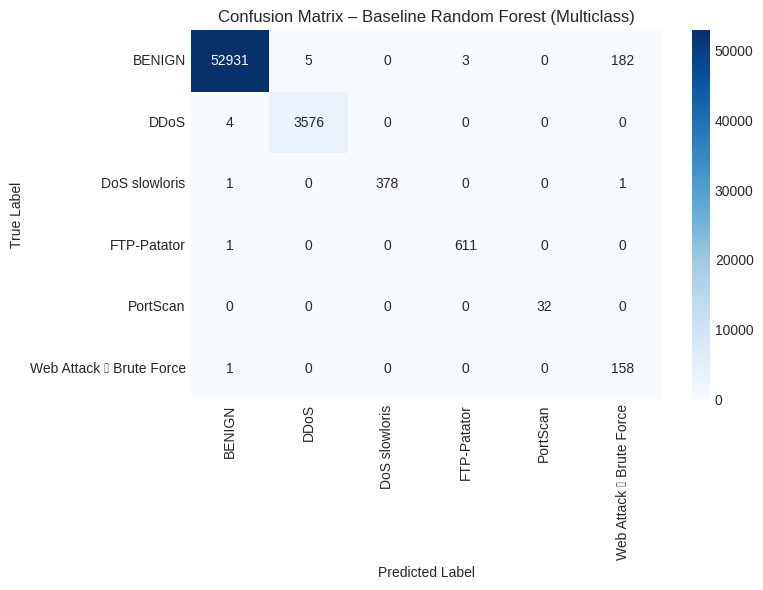

In [37]:
cm = confusion_matrix(y_val, y_val_pred)

class_names = preprocessor.label_encoder.classes_

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix – Baseline Random Forest (Multiclass)')
plt.tight_layout()
plt.show()

## Multiclass ROC–AUC (macro)

In [38]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve

n_classes = len(np.unique(y_train))

# Binarize labels
y_val_bin = label_binarize(y_val, classes=range(n_classes))

# Predict probabilities
y_val_proba = rf_baseline.predict_proba(X_val_scaled)

# Macro ROC-AUC
macro_auc = roc_auc_score(
    y_val_bin,
    y_val_proba,
    average='macro',
    multi_class='ovr'
)

print(f"Macro-average ROC-AUC (OvR): {macro_auc:.4f}")


Macro-average ROC-AUC (OvR): 0.9997


ROC curve for one class (e.g. DDoS)

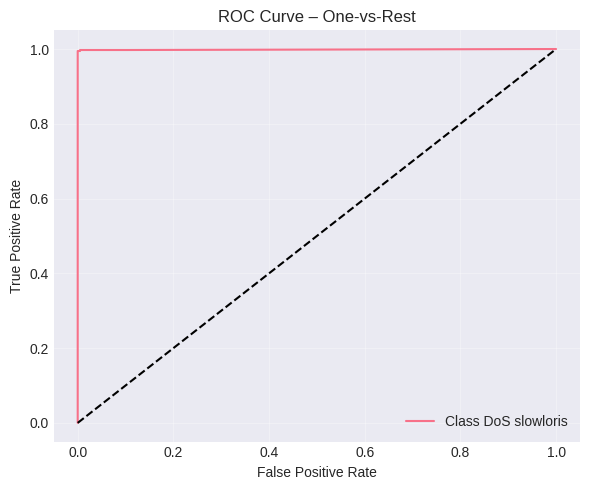

In [39]:
class_idx = 2  # example: DDoS

fpr, tpr, _ = roc_curve(y_val_bin[:, class_idx], y_val_proba[:, class_idx])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'Class {class_names[class_idx]}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – One-vs-Rest')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The Random Forest classifier was trained in multiclass mode to distinguish between benign traffic and multiple attack categories. Multiclass-aware evaluation metrics and One-vs-Rest ROC-AUC analysis were used to assess performance under class imbalance

In [41]:
# Save locally
joblib.dump(rf_baseline, 'rf_baseline.joblib')

# Save to Google Drive (if using Colab)
save_path = '/content/drive/MyDrive/CI CW/rf_baseline.joblib'
joblib.dump(rf_baseline, save_path)

print(f"✓ RF baseline model saved at {save_path}")

✓ RF baseline model saved at /content/drive/MyDrive/CI CW/rf_baseline.joblib


# Train baseline XGBoost (multiclass)

In [43]:
import xgboost as xgb

print("="*60)
print("BASELINE XGBOOST MODEL TRAINING")
print("="*60)

# Start timer
start_time = time.time()

# XGBoost classifier
xgb_baseline = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',  # multiclass classification
    num_class=len(class_names),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

xgb_baseline.fit(X_train_scaled, y_train)

train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} s")

BASELINE XGBOOST MODEL TRAINING
Training time: 450.38 s


In [44]:
# Predictions
y_train_pred = xgb_baseline.predict(X_train_scaled)
y_val_pred = xgb_baseline.predict(X_val_scaled)

### Evaluate baseline XGBoost

In [45]:
xgb_metrics = {
    'train_f1': f1_score(y_train, y_train_pred, average='weighted'),
    'val_f1': f1_score(y_val, y_val_pred, average='weighted'),
    'accuracy': accuracy_score(y_val, y_val_pred),
    'precision': precision_score(y_val, y_val_pred, average='weighted'),
    'recall': recall_score(y_val, y_val_pred, average='weighted'),
}

print("\nBaseline XGBoost Validation Metrics:")
for metric, value in xgb_metrics.items():
    print(f"  {metric}: {value:.4f}")


Baseline XGBoost Validation Metrics:
  train_f1: 0.9999
  val_f1: 0.9993
  accuracy: 0.9993
  precision: 0.9994
  recall: 0.9993


### Confusion Matrix

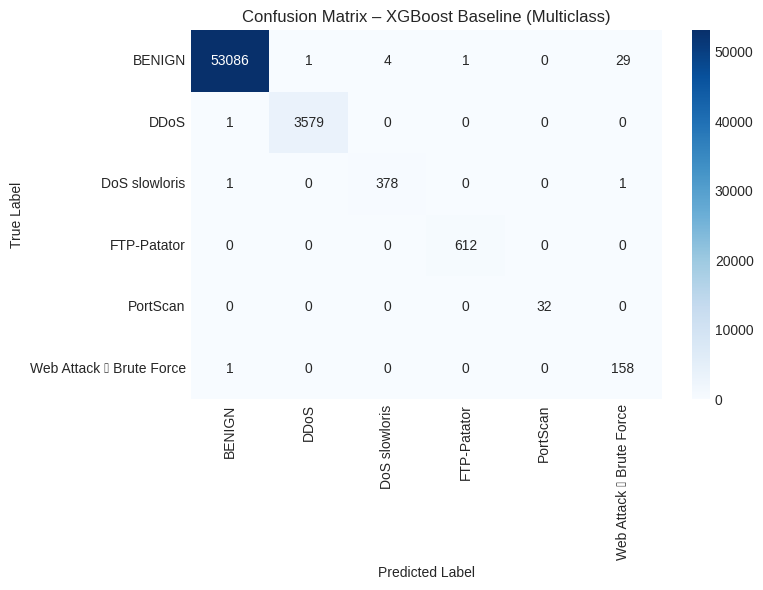

In [46]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix – XGBoost Baseline (Multiclass)')
plt.tight_layout()
plt.show()

### Overfitting Check (Train vs Validation F1)


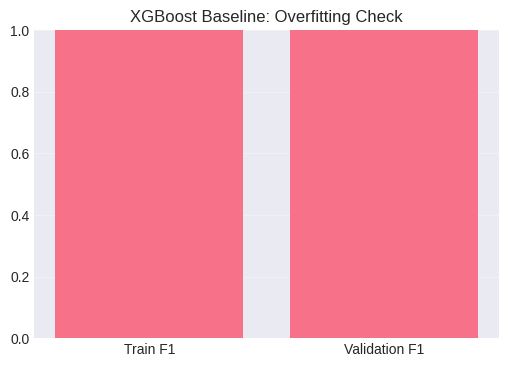

In [47]:
plt.figure(figsize=(6,4))
plt.bar(['Train F1', 'Validation F1'], [xgb_metrics['train_f1'], xgb_metrics['val_f1']])
plt.title('XGBoost Baseline: Overfitting Check')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Feature Importance Plot

<Figure size 1200x600 with 0 Axes>

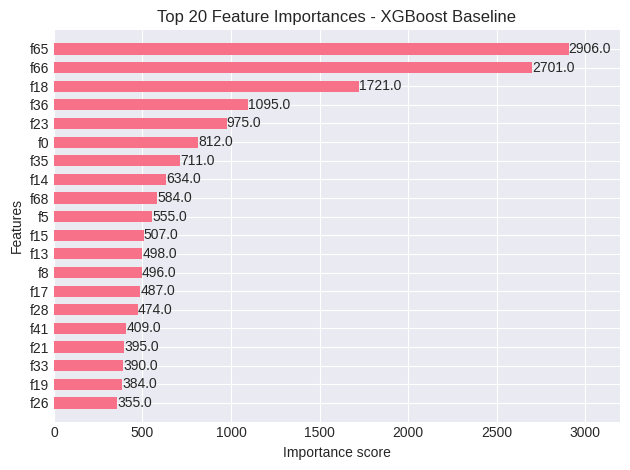

In [48]:
plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_baseline, max_num_features=20, height=0.6, importance_type='weight')
plt.title("Top 20 Feature Importances - XGBoost Baseline")
plt.tight_layout()
plt.show()

### ROC-AUC Curves

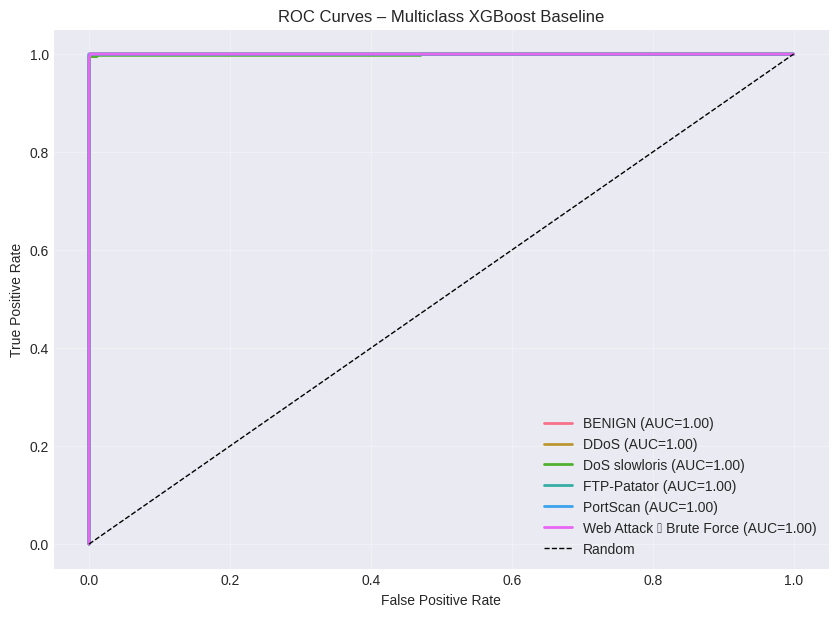

In [49]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels for ROC-AUC
y_val_bin = label_binarize(y_val, classes=np.arange(len(class_names)))
y_val_prob = xgb_baseline.predict_proba(X_val_scaled)

plt.figure(figsize=(10,7))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--', lw=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Multiclass XGBoost Baseline')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [50]:
# Save locally
joblib.dump(xgb_baseline, 'xgb_baseline.joblib')

# Save to Google Drive (if using Colab)
save_path = '/content/drive/MyDrive/CI CW/xgb_baseline.joblib'
joblib.dump(xgb_baseline, save_path)

print(f"✓ XGBoost baseline model saved at {save_path}")

✓ XGBoost baseline model saved at /content/drive/MyDrive/CI CW/xgb_baseline.joblib
